In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm
import matplotlib

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
 
from sklearn.metrics import mean_squared_error

In [2]:
avo = pd.read_csv('avocado.csv', index_col = 0)
avo = avo[avo.region == 'Chicago']
avo = avo[avo.type == 'organic']
avo

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.58,20995.37,1064.71,19320.66,0.0,610.00,610.00,0.00,0.0,organic,2015,Chicago
1,2015-12-20,1.58,22452.30,730.65,21574.99,0.0,146.66,143.33,3.33,0.0,organic,2015,Chicago
2,2015-12-13,1.59,24059.71,876.48,23109.90,0.0,73.33,73.33,0.00,0.0,organic,2015,Chicago
3,2015-12-06,1.59,27081.13,819.66,26104.80,0.0,156.67,156.67,0.00,0.0,organic,2015,Chicago
4,2015-11-29,1.59,22168.32,457.29,21677.70,0.0,33.33,33.33,0.00,0.0,organic,2015,Chicago
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2018-02-04,1.62,46956.84,313.29,32668.25,0.0,13975.30,13975.30,0.00,0.0,organic,2018,Chicago
8,2018-01-28,1.72,40770.94,215.40,31318.93,0.0,9236.61,9236.61,0.00,0.0,organic,2018,Chicago
9,2018-01-21,1.82,36688.67,83.93,28134.16,0.0,8470.58,8470.58,0.00,0.0,organic,2018,Chicago
10,2018-01-14,1.79,44955.89,133.39,31177.44,0.0,13645.06,13635.06,10.00,0.0,organic,2018,Chicago


In [3]:
avo.Date = pd.to_datetime(avo.Date)
avo = avo.sort_values('Date')
avo = avo.reset_index(drop=True)
price = avo[['Date','AveragePrice']]
price = price.set_index('Date')
price

,AveragePrice
Date,
2015-01-04,1.49
2015-01-11,1.79
2015-01-18,1.81
2015-01-25,1.83
2015-02-01,1.52
...,...
2018-02-25,1.68
2018-03-04,1.62
2018-03-11,1.66


In [4]:
price.index = pd.DatetimeIndex(price.index, freq = price.index.inferred_freq)
price.index

DatetimeIndex(['2015-01-04', '2015-01-11', '2015-01-18', '2015-01-25',
               '2015-02-01', '2015-02-08', '2015-02-15', '2015-02-22',
               '2015-03-01', '2015-03-08',
               ...
               '2018-01-21', '2018-01-28', '2018-02-04', '2018-02-11',
               '2018-02-18', '2018-02-25', '2018-03-04', '2018-03-11',
               '2018-03-18', '2018-03-25'],
              dtype='datetime64[ns]', name='Date', length=169, freq='W-SUN')

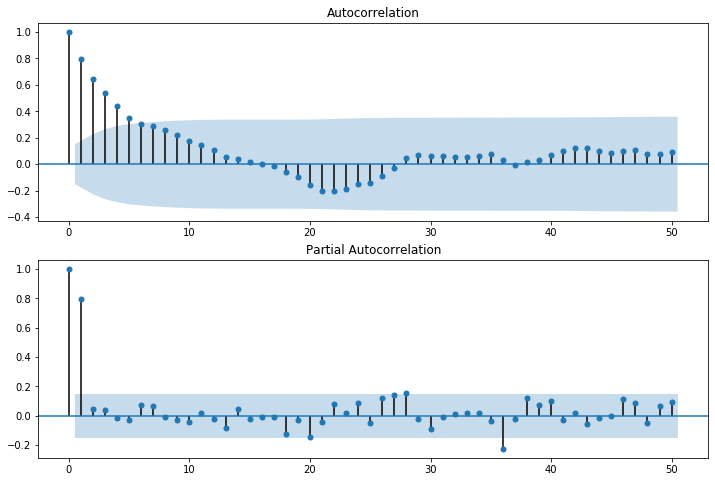

In [5]:
fig, ax = plt.subplots(2,1, figsize= (12,8))
fig = sm.graphics.tsa.plot_acf(price, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(price, lags=50, ax=ax[1])
plt.show()

Optimization terminated successfully.
         Current function value: -0.517291
         Iterations: 4
         Function evaluations: 254


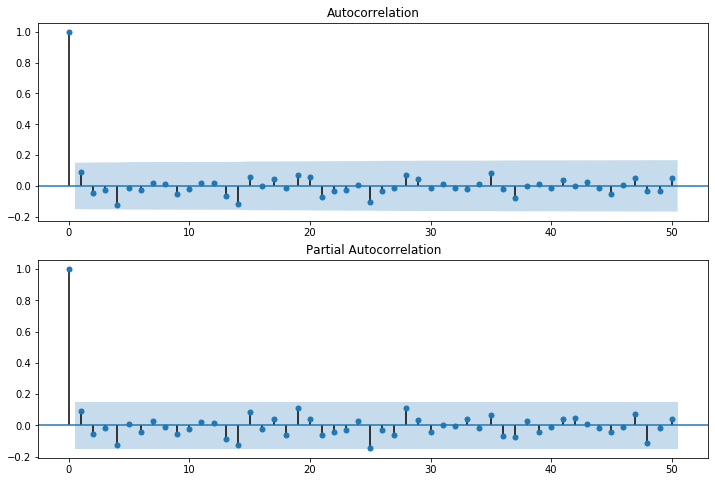

In [6]:
model = sm.tsa.statespace.SARIMAX(price,
                                  order=(1,0,1),
                                  seasonal_order=(1,0,1,52))
mod_results = model.fit(max_iter=50, method='powell')
res = mod_results.resid
fig, ax = plt.subplots(2,1,figsize= (12,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [7]:
p = range(0,2)
d = range(1,2)
q = range(0,6)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

df = pd.DataFrame()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(price,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}- AIC:{}'.format(param, param_seasonal, results.aic))

            combo = [(param,param_seasonal,results.aic)]
            df = df.append(combo)
            print(" ")
        except:
            continue
df.columns = ['param','param_seasonal', 'AIC']

ARIMA(0, 1, 0)x(0, 1, 0, 52)- AIC:-26.643582952177606
 
ARIMA(0, 1, 0)x(1, 1, 0, 52)- AIC:-44.618153111476914
 
ARIMA(0, 1, 1)x(0, 1, 0, 52)- AIC:-24.855772559554744
 
ARIMA(0, 1, 1)x(1, 1, 0, 52)- AIC:-53.25391635257244
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(0, 1, 0, 52)- AIC:-24.242974066253712
 
ARIMA(0, 1, 2)x(1, 1, 0, 52)- AIC:-56.867511253842224
 
ARIMA(0, 1, 3)x(0, 1, 0, 52)- AIC:-22.730770099525653
 
ARIMA(0, 1, 3)x(1, 1, 0, 52)- AIC:-55.61211278407717
 
ARIMA(0, 1, 4)x(0, 1, 0, 52)- AIC:-22.075924076969393
 
ARIMA(0, 1, 4)x(1, 1, 0, 52)- AIC:-53.64674136759456
 
ARIMA(0, 1, 5)x(0, 1, 0, 52)- AIC:-26.291500809446063
 
ARIMA(0, 1, 5)x(1, 1, 0, 52)- AIC:-56.34694292267926
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 0, 52)- AIC:-25.322611977601966
 
ARIMA(1, 1, 0)x(1, 1, 0, 52)- AIC:-47.00982832608471
 
ARIMA(1, 1, 1)x(0, 1, 0, 52)- AIC:-32.49317949434809
 
ARIMA(1, 1, 1)x(1, 1, 0, 52)- AIC:-55.28706699085599
 
ARIMA(1, 1, 2)x(0, 1, 0, 52)- AIC:-29.325814151282593
 
ARIMA(1, 1, 2)x(1, 1, 0, 52)- AIC:-56.56104198878032
 
ARIMA(1, 1, 3)x(0, 1, 0, 52)- AIC:-27.955606507533524
 
ARIMA(1, 1, 3)x(1, 1, 0, 52)- AIC:-54.67319126696873
 
ARIMA(1, 1, 4)x(0, 1, 0, 52)- AIC:-27.70275228735025
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 4)x(1, 1, 0, 52)- AIC:-54.44152485338809
 
ARIMA(1, 1, 5)x(0, 1, 0, 52)- AIC:-25.989241749558325
 
ARIMA(1, 1, 5)x(1, 1, 0, 52)- AIC:-56.79899511696715
 


In [8]:
df = df.sort_values('AIC').reset_index(drop = True)
df.head()

,param,param_seasonal,AIC
0,"(0, 1, 2)","(1, 1, 0, 52)",-56.867511
1,"(1, 1, 5)","(1, 1, 0, 52)",-56.798995
2,"(1, 1, 2)","(1, 1, 0, 52)",-56.561042
3,"(0, 1, 5)","(1, 1, 0, 52)",-56.346943
4,"(0, 1, 3)","(1, 1, 0, 52)",-55.612113


### The above output suggests that SARIMAX(1, 1, 2)x(1, 1, 0, 52) yields the lowest AIC value of -56.867511. Therefore we should consider this to be optimal option.

In [9]:
mod = sm.tsa.statespace.SARIMAX(price,
                                order=(1, 1, 2),
                                seasonal_order=(1, 1, 0, 52))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       AveragePrice   No. Observations:                  169
Model:             SARIMAX(1, 1, 2)x(1, 1, 0, 52)   Log Likelihood                  37.691
Date:                            Wed, 06 May 2020   AIC                            -65.381
Time:                                    00:05:09   BIC                            -51.613
Sample:                                01-04-2015   HQIC                           -59.792
                                     - 03-25-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7528      0.136      5.552      0.000       0.487       1.019
ma.L1         -1.0093      0.453   

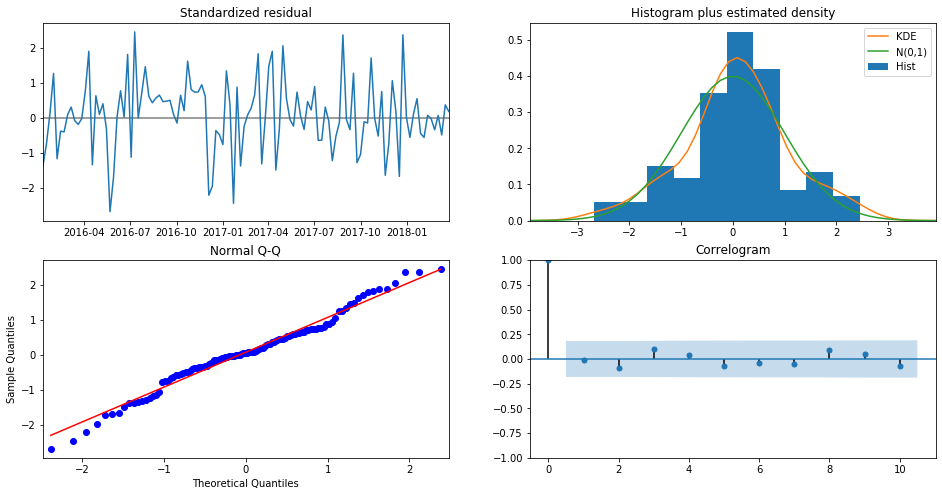

In [10]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [11]:
price.iloc[157]

AveragePrice    1.83
Name: 2018-01-07 00:00:00, dtype: float64

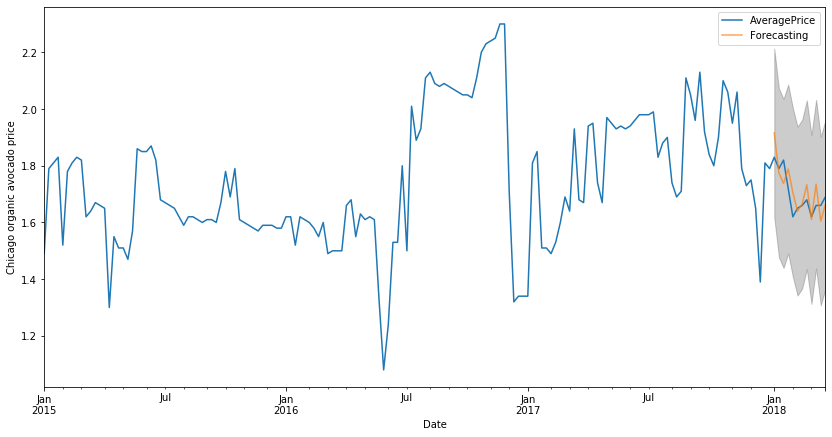

In [12]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-07'), dynamic=False)
pred_ci = pred.conf_int()
ax = price.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecasting', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Chicago organic avocado price')
plt.legend()
plt.show()

In [13]:
print(price.index[157:,])
price2018 = price.iloc[157:,]
price2018
pred.predicted_mean
price_observed = price2018.AveragePrice
(pred.predicted_mean,price_observed)


DatetimeIndex(['2018-01-07', '2018-01-14', '2018-01-21', '2018-01-28',
               '2018-02-04', '2018-02-11', '2018-02-18', '2018-02-25',
               '2018-03-04', '2018-03-11', '2018-03-18', '2018-03-25'],
              dtype='datetime64[ns]', name='Date', freq=None)


(Date
 2018-01-07    1.915903
 2018-01-14    1.774880
 2018-01-21    1.737576
 2018-01-28    1.788546
 2018-02-04    1.706095
 2018-02-11    1.639842
 2018-02-18    1.664516
 2018-02-25    1.733043
 2018-03-04    1.610359
 2018-03-11    1.735319
 2018-03-18    1.604931
 2018-03-25    1.663070
 Freq: W-SUN, dtype: float64, Date
 2018-01-07    1.83
 2018-01-14    1.79
 2018-01-21    1.82
 2018-01-28    1.72
 2018-02-04    1.62
 2018-02-11    1.65
 2018-02-18    1.66
 2018-02-25    1.68
 2018-03-04    1.62
 2018-03-11    1.66
 2018-03-18    1.66
 2018-03-25    1.69
 Freq: W-SUN, Name: AveragePrice, dtype: float64)

In [14]:
price_forecasted = pred.predicted_mean
price_observed = price2018.AveragePrice
mse = ((price_forecasted - price_observed) ** 2).mean()
print('The Mean Squared Error: {}'.format(mse))

print('The Root Mean Squared Error: {}'.format(np.sqrt(mse), 2))

The Mean Squared Error: 0.003247783029310092
The Root Mean Squared Error: 0.05698932381867758


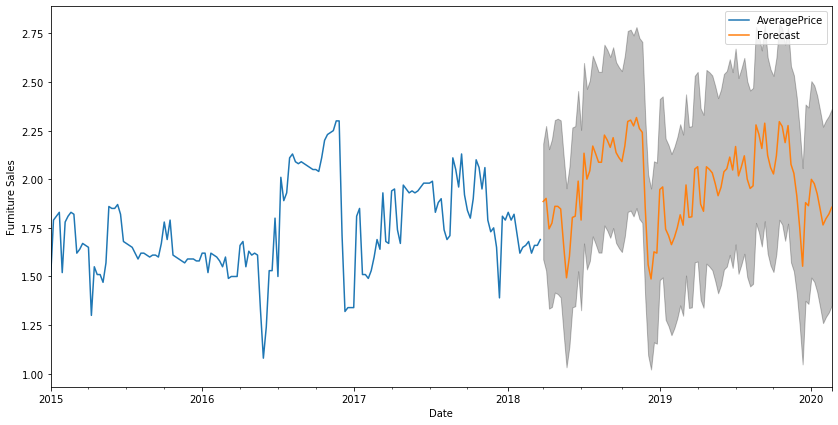

In [15]:
pred_uc = results.get_forecast(steps = 100)
pred_ci = pred_uc.conf_int()
ax = price.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()